
# Predict Home Value of Zillow Listings

**Alec Hartman**

**April 13, 2020**

## Goals
1. Develop a model to predict home values using square feet, bedrooms, and bathrooms.
2. Create a summary [presentation](https://docs.google.com/presentation/d/1ECtW4r91m_6WJGXTojXHFAnLWTK0KJ-z5euiXm5XgHI/edit?usp=sharing) describing the drivers of single unit property values.
3. Plot distributions of tax rates for each county, and provide key measures of central tendency and measures of spread.

---
### 1. Acquire + Preparation (aka Wrangling)

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import math
from scipy import stats
from statsmodels.formula.api import ols

import sklearn
import sklearn.metrics
import sklearn.linear_model
import sklearn.feature_selection

import wrangle as wr
import split_scale as ss
import explore as ex
import evaluate as ev

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = wr.wrangle_zillow()
df

,bathrooms,bedrooms,square_feet,fips_code,property_description,home_value,tax_amount,tax_rate,transaction_date,county
0,2.5,3.0,1653.0,6059,Single Family Residential,605000.0,6185.28,0.010224,2017-05-01,Orange County
1,3.0,3.0,1572.0,6037,Single Family Residential,404060.0,4934.43,0.012212,2017-05-01,Los Angeles County
2,3.0,4.0,3041.0,6037,Single Family Residential,245311.0,2963.65,0.012081,2017-05-01,Los Angeles County
3,2.0,3.0,1692.0,6037,Single Family Residential,649169.0,8063.11,0.012421,2017-05-01,Los Angeles County
4,2.0,4.0,1611.0,6037,Single Family Residential,89640.0,1144.73,0.012770,2017-05-01,Los Angeles County
...,...,...,...,...,...,...,...,...,...,...
14984,3.0,5.0,2526.0,6059,Single Family Residential,458903.0,5718.72,0.012462,2017-06-30,Orange County
14985,3.0,5.0,2735.0,6059,Single Family Residential,115387.0,1465.88,0.012704,2017-06-30,Orange County
14986,2.0,3.0,1536.0,6037,Single Family Residential,297097.0,3519.78,0.011847,2017-06-30,Los Angeles County
14987,3.0,5.0,2655.0,6059,Single Family Residential,746963.0,8065.50,0.010798,2017-06-30,Orange County


### Data Dictionary
- **bathrooms**:
    - The number of bathrooms in each home
    - zillow SQL database field: properties_2017.bathroomcnt
    - Homes with zero bathrooms were filtered out in my SQL query
    - I chose this field to represent the number of bathrooms per home as it appears to be the most complete and appropriate field in the database
- **bedrooms**:
    - The number of bedrooms in each home
    - zillow SQL database field: properties_2017.bedroomcnt
    - Homes with zero bedrooms were filtered out in my SQL query
    - I chose this field to represent the number of bedrooms per home as it appears to be the most complete and appropriate field in the database
- **square_feet**:
    - The square footage of each home
    - zillow SQL database field: properties_2017.calculatedfinishedsquarefeet
    - I chose this field to represent square footage per home as it appears to be the most complete and appropriate field in the database
- **fips_code**:
    - The Federal Information Processing System (FIPS) code for each home. Essentially, this is a state and county unique identifier established by the Federal Communications Commission (FCC)
    - zillow SQL database field: properties_2017.fips
    - I chose to use this field to index the county in which each home is located 
- **property_description**:
    - The property description of each home
    - zillow SQL database field: propertylandusetype.propertylandusedesc
    - I filtered the data in my SQL query to include Single Family Residential properties only
    - I chose to use and filter by this field as I interpreted the term "single unit properties" from the project specifications to mean Single Family Residential properties
- **home_value**:
    - The property's tax assessed value in 2017, presumably
    - zillow SQL database field: properties_2017.taxvaluedollarcnt
    - I used this field to represent home value as suggested in the project specifications
- **tax_amount**:
    - The amount of tax paid on each property in 2017, presumably
    - zillow SQL database field: properties_2017.taxamount
    - I used this field to represent tax amount and calculate the tax rate for each property
- **tax_rate**:
    - The tax rate for each property in 2017, presumably
    - zillow SQL database fields: (properties_2017.taxamount/properties_2017.taxvaluedollarcnt) as tax_rate
    - I used the fields above to calculate the tax rate for each property
- **transaction_date**:
    - The last transaction date for each property
    - zillow SQL database field: predictions_2017.transactiondate
    - I filtered the data in my SQL query to include only those homes whose last transaction date was in the "hot months" of May and June in terms of real estate demand as per the project specifications
    - I chose to use and filter by this field as appears to be the most appropriate date field in the database
- **county**:
    - The county in which each property is located
    - This field was indexed using the FIPS codes provided by the FCC as mentioned above. You can reference the website where this information was found by following this [link](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt).
    - I chose to include this field in my DataFrame it will be used to plot the distribution of tax rates by county

#### In which state and counties are these listing located?

In [3]:
df.county.unique()

array(['Orange County', 'Los Angeles County', 'Ventura County'],
      dtype=object)

> All properties contained in the DataFrame above are in the California counties of Los Angeles, Orange, and Ventura.

#### Let's ensure our data is truly ready to analyze.

In [4]:
assert (df.bathrooms == 0).sum() == 0, "If you see an AssertionError, there are zero values in the bathrooms feature."
assert (df.bedrooms == 0).sum() == 0, "If you see an AssertionError, there are zero values in the bedrooms feature."
assert (df.square_feet == 0).sum() == 0, "If you see an AssertionError, there are zero values in the square_feet feature."
assert (df.fips_code == 0).sum() == 0, "If you see an AssertionError, there are zero values in the fips_code feature."
assert (df.home_value == 0).sum() == 0, "If you see an AssertionError, there are zero values in the tax_value feature."
assert (df.tax_amount == 0).sum() == 0, "If you see an AssertionError, there are zero values in the tax_amount feature."
assert (df.tax_rate == 0).sum() == 0, "If you see an AssertionError, there are zero values in the tax_rate feature."

In [5]:
df.isnull().sum()

bathrooms               0
bedrooms                0
square_feet             0
fips_code               0
property_description    0
home_value              0
tax_amount              0
tax_rate                0
transaction_date        0
county                  0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14989 entries, 0 to 14988
Data columns (total 10 columns):
bathrooms               14989 non-null float64
bedrooms                14989 non-null float64
square_feet             14989 non-null float64
fips_code               14989 non-null int64
property_description    14989 non-null object
home_value              14989 non-null float64
tax_amount              14989 non-null float64
tax_rate                14989 non-null float64
transaction_date        14989 non-null object
county                  14989 non-null object
dtypes: float64(6), int64(1), object(3)
memory usage: 1.1+ MB


In [7]:
df.describe()

,bathrooms,bedrooms,square_feet,fips_code,home_value,tax_amount,tax_rate
count,14989.000000,14989.000000,14989.000000,14989.000000,1.498900e+04,14989.000000,14989.000000
mean,2.329175,3.316899,1943.199013,6049.382547,5.417072e+05,6597.894501,0.013430
std,1.019406,0.936278,1001.275534,21.226074,7.309616e+05,8453.776520,0.006885
min,1.000000,1.000000,300.000000,6037.000000,1.050400e+04,51.260000,0.000787
25%,2.000000,3.000000,1276.000000,6037.000000,1.990000e+05,2710.810000,0.011602
50%,2.000000,3.000000,1680.000000,6037.000000,3.852590e+05,4776.080000,0.012305
75%,3.000000,4.000000,2346.000000,6059.000000,6.449720e+05,7678.440000,0.013693
max,11.000000,12.000000,15450.000000,6111.000000,2.385837e+07,276797.830000,0.452884


In [8]:
train, test = ss.split_my_data(df)

In [9]:
train.head()

,bathrooms,bedrooms,square_feet,fips_code,property_description,home_value,tax_amount,tax_rate,transaction_date,county
14440,2.0,3.0,1410.0,6037,Single Family Residential,100794.0,2269.73,0.022519,2017-06-30,Los Angeles County
6848,1.0,2.0,806.0,6037,Single Family Residential,270789.0,3686.09,0.013612,2017-05-31,Los Angeles County
14624,2.0,3.0,1821.0,6037,Single Family Residential,238358.0,3132.04,0.013140,2017-06-30,Los Angeles County
10263,2.0,4.0,1697.0,6111,Single Family Residential,365558.0,4139.56,0.011324,2017-06-15,Ventura County
4870,2.0,3.0,1618.0,6059,Single Family Residential,70667.0,1038.24,0.014692,2017-05-23,Orange County


In [10]:
test.head()

,bathrooms,bedrooms,square_feet,fips_code,property_description,home_value,tax_amount,tax_rate,transaction_date,county
7790,2.5,3.0,2210.0,6059,Single Family Residential,949258.0,9624.54,0.010139,2017-06-02,Orange County
406,2.5,4.0,2373.0,6059,Single Family Residential,674071.0,7572.44,0.011234,2017-05-02,Orange County
5985,2.0,4.0,1919.0,6037,Single Family Residential,286663.0,5219.87,0.018209,2017-05-26,Los Angeles County
5554,2.0,4.0,1600.0,6059,Single Family Residential,400489.0,4608.84,0.011508,2017-05-25,Orange County
14479,3.0,3.0,1824.0,6037,Single Family Residential,495000.0,6126.89,0.012378,2017-06-30,Los Angeles County


In [11]:
train.shape[0] / df.shape[0]

0.7999866568817132

In [12]:
test.shape[0] / df.shape[0]

0.20001334311828675

In [13]:
train = train[["square_feet", "bedrooms", "bathrooms", "home_value"]]
test = test[["square_feet", "bedrooms", "bathrooms", "home_value"]]

In [14]:
train.head()

,square_feet,bedrooms,bathrooms,home_value
14440,1410.0,3.0,2.0,100794.0
6848,806.0,2.0,1.0,270789.0
14624,1821.0,3.0,2.0,238358.0
10263,1697.0,4.0,2.0,365558.0
4870,1618.0,3.0,2.0,70667.0


In [15]:
test.head()

,square_feet,bedrooms,bathrooms,home_value
7790,2210.0,3.0,2.5,949258.0
406,2373.0,4.0,2.5,674071.0
5985,1919.0,4.0,2.0,286663.0
5554,1600.0,4.0,2.0,400489.0
14479,1824.0,3.0,3.0,495000.0


---
### 2. Explore

#### Distribution of Tax Rates by County

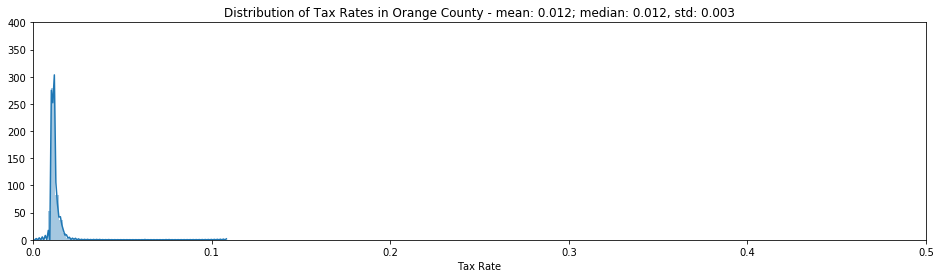

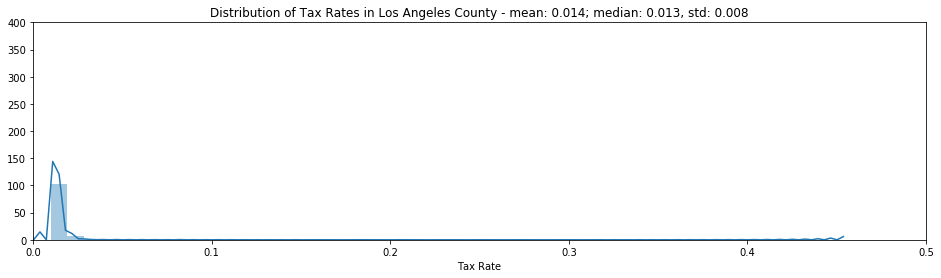

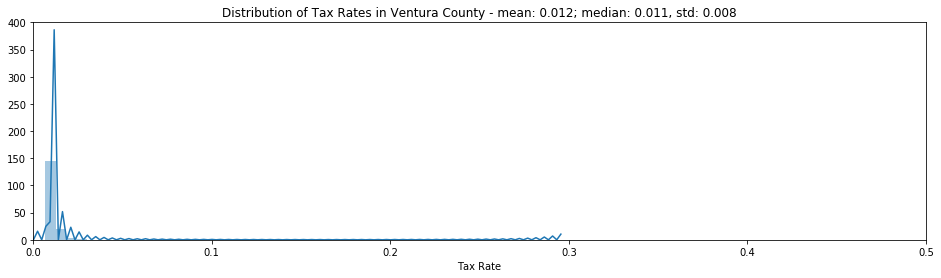

In [16]:
for county in df.county.unique():
    plt.figure(figsize=(16, 4))
    plt.title(f"Distribution of Tax Rates in {county} - mean: {df[df.county == county].tax_rate.mean():.3f}; median: {df[df.county == county].tax_rate.median():.3f}, std: {df[df.county == county].tax_rate.std():.3f}")
    sns.distplot(df[df.county == county].tax_rate)
    plt.xlabel("Tax Rate")
    plt.xlim(0, 0.50)
    plt.ylim(0, 400)
    plt.show()

#### Statistical Testing

> Is the home value in Los Angeles County higher than the average home value? 

$H_0$: There is no difference in home value between homes located in Los Angeles County and the average home.

$H_a$: There is a difference in home value between homes located in Los Angeles County and the average home.

In [17]:
alpha = .01

x = df[df.county == "Los Angeles County"].home_value
mu = df.home_value.mean()

t_stat, p = stats.ttest_1samp(x, mu)
print(f"t = {t_stat:.3}")
print(f"p = {p:.3}")

if p < alpha:
    print("Reject null hypothesis.")
else:
    print("Fail to reject null hypothesis")

t = -3.25
p = 0.00116
Reject null hypothesis.


> Is the tax rate correlated with square feet? 

$H_0$: There is no linear relationship between tax rate and square feet.

$H_a$: There is a linear relationship between tax rate and square feet.

In [18]:
r, p = stats.pearsonr(df.tax_rate, df.square_feet)
print("r =", r)
print("p =", p)

if p < alpha:
    print("Reject null hypothesis.")
else:
    print("Fail to reject null hypothesis")

r = -0.095110457255379
p = 1.8180142636792613e-31
Reject null hypothesis.


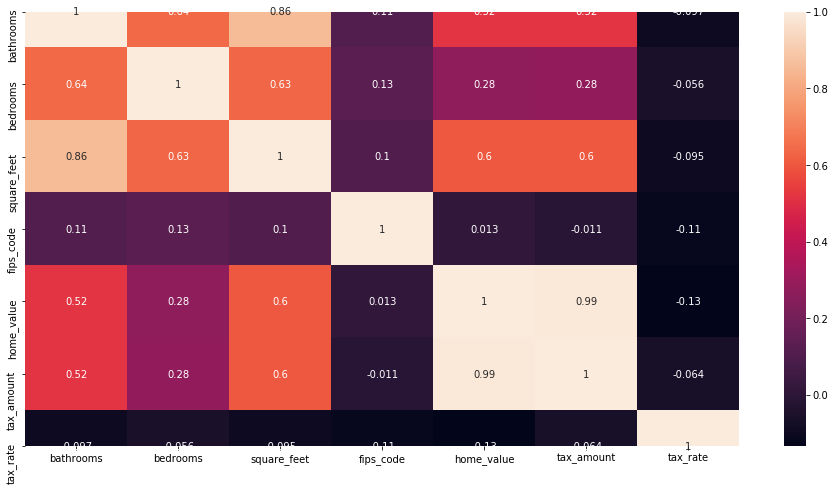

In [19]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), annot=True)
plt.show()

#### Plotting Variable Pairs of Train DataFrame

<Figure size 1152x576 with 0 Axes>

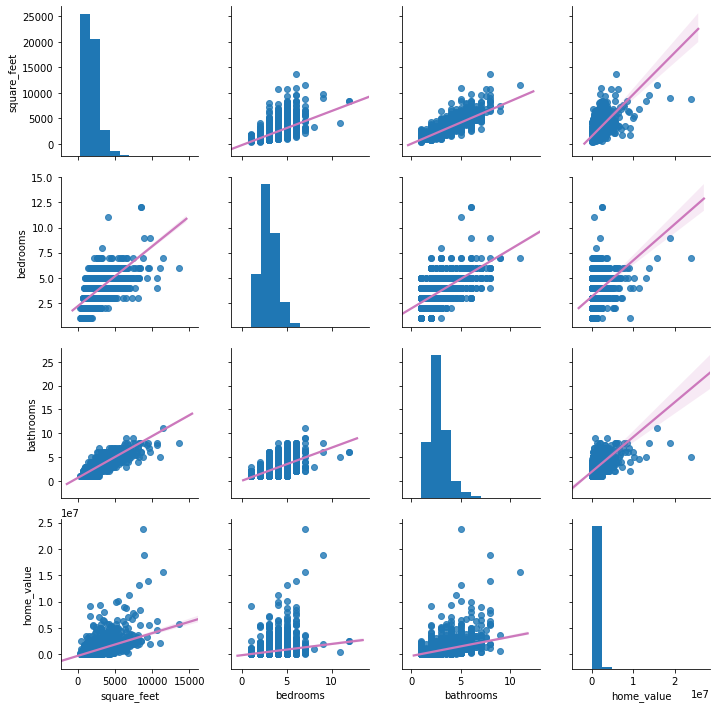

In [20]:
plt.figure(figsize=(16, 8))
sns.pairplot(data=train, kind="reg", plot_kws={"line_kws": {"color": sns.color_palette("colorblind")[4]}})
plt.show()

> **Observations**:
>    - square_feet and bathrooms have a strong, positive linear relationship
>    - home_value and square_feet have a strong, positive linear relationship
>    - home_value and bedrooms have a positive linear relationship
>    - home_value and bathrooms have a positive linear relationship
>    - bathrooms and bedrooms have a positive linear relationship

---
### 3. Model

### Hypothesis

$H_0$: Single unit property value is independent of square footage, number of bedrooms, and number of bathrooms

$H_a$: Single unit property value is dependent on square footage, number of bedrooms, and number of bathrooms

---
#### Linear Regression Model

In [21]:
pd.options.display.float_format = '{:.3f}'.format

In [22]:
print(f"Mean home_value = {train.home_value.mean():.2f}")
print(f"Median home_value = {train.home_value.median():.2f}")

Mean home_value = 539045.85
Median home_value = 387093.00


> I chose the median home_value of the train dataset to be my baseline because the mean is heavily influenced by outliers.

In [23]:
predictions = pd.DataFrame({
    "actual_home_value": train.home_value,
    "baseline_home_value": train.home_value.median()
})
predictions.head()

,actual_home_value,baseline_home_value
14440,100794.000,387093.000
6848,270789.000,387093.000
14624,238358.000,387093.000
10263,365558.000,387093.000
4870,70667.000,387093.000


In [24]:
train.shape

(11991, 4)

In [25]:
# feature
X = train[["square_feet", "bedrooms", "bathrooms"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ square_feet + bedrooms + bathrooms"] = lm.predict(X)
predictions.head()

,actual_home_value,baseline_home_value,home_value ~ square_feet + bedrooms + bathrooms
14440,100794.000,387093.000,316618.996
6848,270789.000,387093.000,113190.188
14624,238358.000,387093.000,503913.254
10263,365558.000,387093.000,310619.601
4870,70667.000,387093.000,411405.384


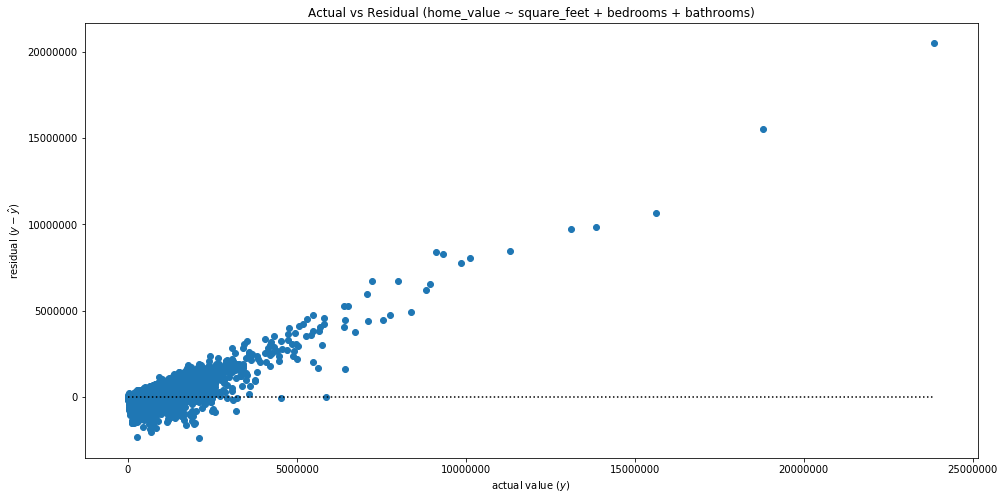

In [26]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(predictions.actual_home_value, predictions["home_value ~ square_feet + bedrooms + bathrooms"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [27]:
print(f"""The equation of our regression line is: 
y = ({lm.coef_[0]:.2f} * square_feet) + ({lm.coef_[1]:.2f} * bedrooms) + ({lm.coef_[-1]:.2f} * bathrooms) + {lm.intercept_:.2f}""")

The equation of our regression line is: 
y = (455.70 * square_feet) + (-136786.38 * bedrooms) + (64970.10 * bathrooms) + -45504.40


In [28]:
ev.regression_errors(predictions.actual_home_value, predictions["home_value ~ square_feet + bedrooms + bathrooms"], predictions)

SSE    3861956734638948.500
ESS    2276905404349229.000
TSS    6138862138988178.000
MSE        322071281347.590
RMSE             567513.243
dtype: float64

In [29]:
predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual_home_value, c)))

actual_home_value                                      0.000
baseline_home_value                               731468.032
home_value ~ square_feet + bedrooms + bathrooms   567513.243
dtype: float64

In [30]:
ev.better_than_baseline(predictions.actual_home_value, predictions["home_value ~ square_feet + bedrooms + bathrooms"], predictions.baseline_home_value, predictions)

Model performs better than baseline


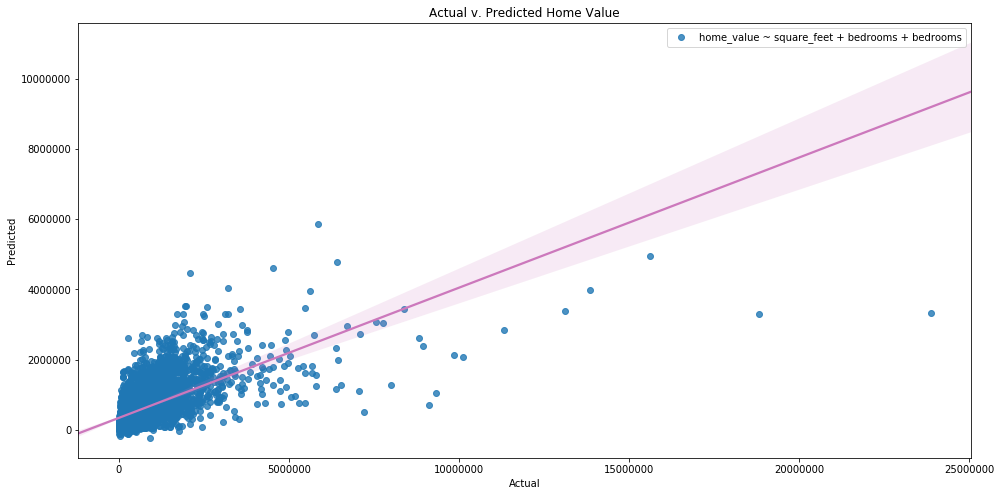

In [31]:
plt.figure(figsize=(16, 8))
sns.regplot(x=predictions.actual_home_value, y=predictions["home_value ~ square_feet + bedrooms + bathrooms"], data=predictions, label="home_value ~ square_feet + bedrooms + bedrooms", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Home Value")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
### Let's test our Linear Regression model

In [32]:
X_test = test[["square_feet", "bedrooms", "bathrooms"]]

test["yhat"] = lm.predict(X_test)
test.head()

,square_feet,bedrooms,bathrooms,home_value,yhat
7790,2210.000,3.000,2.500,949258.000,713667.080
406,2373.000,4.000,2.500,674071.000,651160.415
5985,1919.000,4.000,2.000,286663.000,411785.843
5554,1600.000,4.000,2.000,400489.000,266416.333
14479,1824.000,3.000,3.000,495000.000,570250.466


In [33]:
ev.regression_errors(test.home_value, test.yhat, test)

SSE    1082389583418842.125
ESS     655770599281738.000
TSS    1738160182700580.000
MSE        361037219285.805
RMSE             600863.728
dtype: float64

In [34]:
test["yhat_baseline"] = test.home_value.median()
test.head()

,square_feet,bedrooms,bathrooms,home_value,yhat,yhat_baseline
7790,2210.000,3.000,2.500,949258.000,713667.080,372421.500
406,2373.000,4.000,2.500,674071.000,651160.415,372421.500
5985,1919.000,4.000,2.000,286663.000,411785.843,372421.500
5554,1600.000,4.000,2.000,400489.000,266416.333,372421.500
14479,1824.000,3.000,3.000,495000.000,570250.466,372421.500


In [35]:
ev.baseline_errors(test.home_value, test.yhat_baseline, test)

SSE_baseline    1965933579672869.500
MSE_baseline        655748358796.821
RMSE_baseline             809782.908
dtype: float64

In [36]:
ev.better_than_baseline(test.home_value, test.yhat, test.yhat_baseline, test)

Model performs better than baseline


In [37]:
test.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(test.home_value, c)))[4:]

yhat            600863.728
yhat_baseline   809782.908
dtype: float64

In [38]:
print(f'Coefficient of determination, or explained variance: {sklearn.metrics.r2_score(test.home_value, test.yhat):.2f}')

Coefficient of determination, or explained variance: 0.42


In [39]:
sklearn.feature_selection.f_regression(test[["square_feet", "bedrooms", "bathrooms"]], test.home_value)

(array([1972.22646268,  241.52032398, 1151.01214792]),
 array([0.00000000e+000, 1.93545613e-052, 8.58466946e-214]))

> My model is off on it's predictions of home_value by, on average, 600,863.73 dollars which is better than the baseline model by ~200,000 dollars.

> 42% of the variance in home_value can be explained by the square_feet, bedrooms, and bathrooms in my model.

> Reject null hypothesis, "Single unit property value is independent of square footage, number of bedrooms, and number of bathrooms"

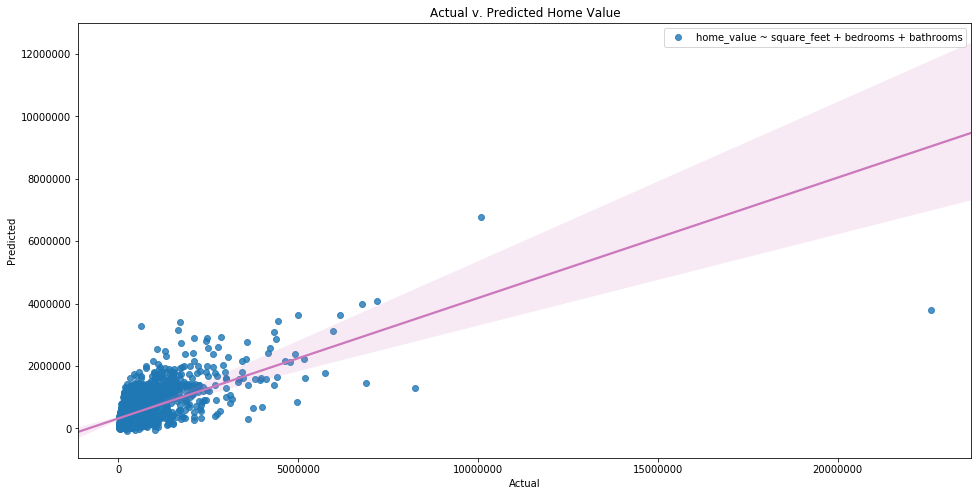

In [40]:
plt.figure(figsize=(16, 8))
sns.regplot(x=test.home_value, y=test.yhat, data=test, label="home_value ~ square_feet + bedrooms + bathrooms", line_kws={"color": sns.color_palette("colorblind")[4]})
plt.ticklabel_format(axis="both", style="plain")

plt.title("Actual v. Predicted Home Value")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()

plt.show()

---
#### Using ols to Compare Findings with sklearn 

In [41]:
model = ols("home_value ~ square_feet + bedrooms + bathrooms", test).fit()

In [42]:
actual = test.home_value
predicted = model.predict()

In [43]:
ev.model_significance(model)

{'r^2 -- explained variance': 0.42855994200146696,
 'p-value for model significance': 0.0}

In [44]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             home_value   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     748.5
Date:                Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                        21:02:43   Log-Likelihood:                -44126.
No. Observations:                2998   AIC:                         8.826e+04
Df Residuals:                    2994   BIC:                         8.828e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    5.836e+04      4e+04      1.458      0.145   -2.01e+04    1.37e+05
square_feet   559.6853     20.649     27.105      0.000     519.199     600.172
bedrooms    -1.973e+05   1.56e+04    -12.663      0.000   -2.28e+05   -1.67e+05
bathrooms    2.876e+04   2.14e+04      1.347      0.178   -1.31e+04    7.06e+04
==============================================================================
Omnibus:                     5147.282   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11899419.438
Skew:                          11.279   Prob(JB):                         0.00
Kurtosis:                     310.815   Cond. No.                     8.44e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---
### Additional Models

In [45]:
# feature
X = train[["square_feet"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ square_feet"] = lm.predict(X)
predictions.head()

,actual_home_value,baseline_home_value,home_value ~ square_feet + bedrooms + bathrooms,home_value ~ square_feet
14440,100794.000,387093.000,316618.996,307607.662
6848,270789.000,387093.000,113190.188,47210.750
14624,238358.000,387093.000,503913.254,484798.276
10263,365558.000,387093.000,310619.601,431339.307
4870,70667.000,387093.000,411405.384,397280.771


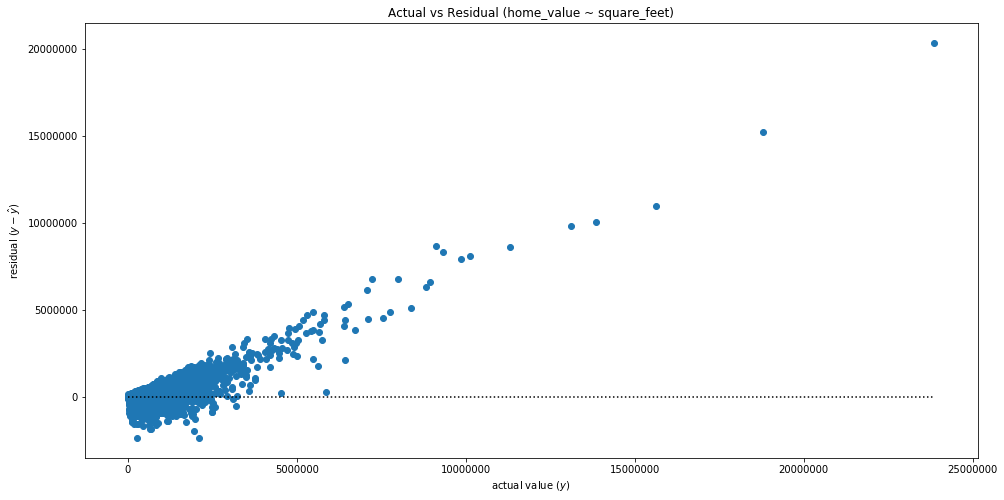

In [46]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(predictions.actual_home_value, predictions["home_value ~ square_feet"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [47]:
ev.regression_errors(predictions.actual_home_value, predictions["home_value ~ square_feet"], predictions)

SSE    3973079860291705.000
ESS    2165782278696725.000
TSS    6138862138988430.000
MSE        331338492226.812
RMSE             575620.094
dtype: float64

In [48]:
ev.baseline_errors(predictions.actual_home_value, predictions.baseline_home_value, predictions)

SSE_baseline    6415730366586437.000
MSE_baseline        535045481326.531
RMSE_baseline             731468.032
dtype: float64

In [49]:
ev.better_than_baseline(predictions.actual_home_value, predictions["home_value ~ square_feet"], predictions.baseline_home_value, predictions)

Model performs better than baseline


In [50]:
predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual_home_value, c)))

actual_home_value                                      0.000
baseline_home_value                               731468.032
home_value ~ square_feet + bedrooms + bathrooms   567513.243
home_value ~ square_feet                          575620.094
dtype: float64

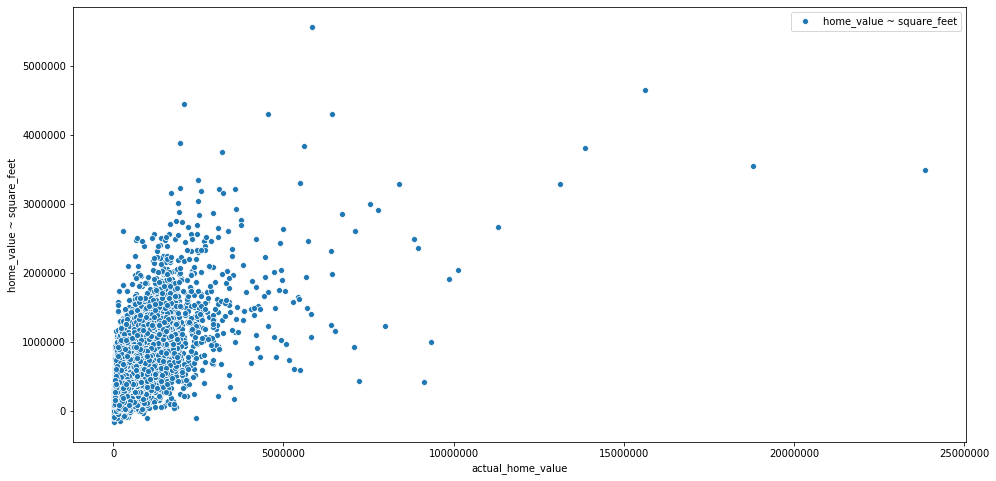

In [51]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x=predictions.actual_home_value, y=predictions["home_value ~ square_feet"], label="home_value ~ square_feet")
plt.ticklabel_format(axis="both", style="plain")
plt.show()

---

In [52]:
# feature
X = train[["bedrooms"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ bedrooms"] = lm.predict(X)
predictions.head()

,actual_home_value,baseline_home_value,home_value ~ square_feet + bedrooms + bathrooms,home_value ~ square_feet,home_value ~ bedrooms
14440,100794.000,387093.000,316618.996,307607.662,471002.986
6848,270789.000,387093.000,113190.188,47210.750,258084.923
14624,238358.000,387093.000,503913.254,484798.276,471002.986
10263,365558.000,387093.000,310619.601,431339.307,683921.049
4870,70667.000,387093.000,411405.384,397280.771,471002.986


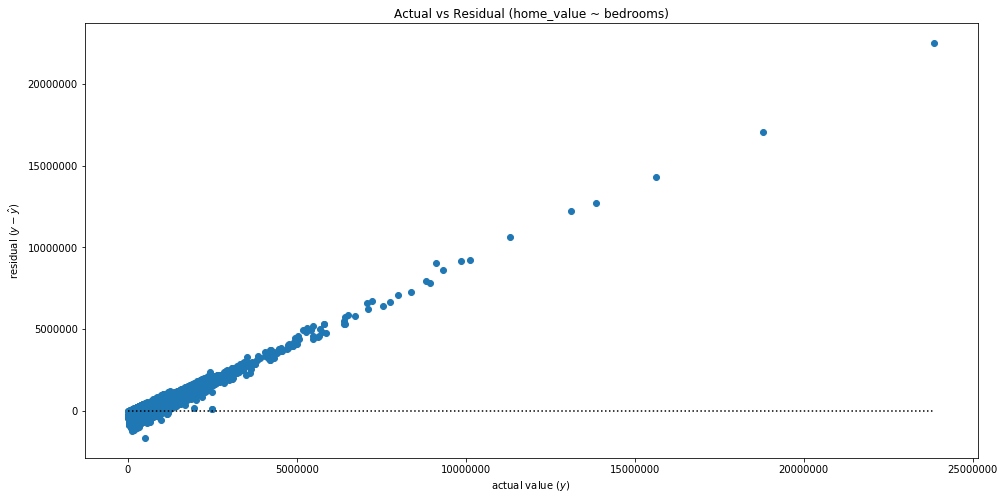

In [53]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(predictions.actual_home_value, predictions["home_value ~ bedrooms"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [54]:
ev.regression_errors(predictions.actual_home_value, predictions["home_value ~ bedrooms"], predictions)

SSE    5667596190457278.000
ESS     471265948531274.625
TSS    6138862138988553.000
MSE        472654173167.982
RMSE             687498.490
dtype: float64

In [55]:
ev.better_than_baseline(predictions.actual_home_value, predictions["home_value ~ bedrooms"], predictions.baseline_home_value, predictions)

Model performs better than baseline


In [56]:
predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual_home_value, c)))

actual_home_value                                      0.000
baseline_home_value                               731468.032
home_value ~ square_feet + bedrooms + bathrooms   567513.243
home_value ~ square_feet                          575620.094
home_value ~ bedrooms                             687498.490
dtype: float64

---

In [57]:
# feature
X = train[["bathrooms"]]
# target
y = train.home_value

# 1. Make the model
lm = sklearn.linear_model.LinearRegression()
# 2. Fit the model
lm.fit(X, y)
# 3. Use the model
predictions["home_value ~ bathrooms"] = lm.predict(X)
predictions.head()

,actual_home_value,baseline_home_value,home_value ~ square_feet + bedrooms + bathrooms,home_value ~ square_feet,home_value ~ bedrooms,home_value ~ bathrooms
14440,100794.000,387093.000,316618.996,307607.662,471002.986,418649.129
6848,270789.000,387093.000,113190.188,47210.750,258084.923,54910.879
14624,238358.000,387093.000,503913.254,484798.276,471002.986,418649.129
10263,365558.000,387093.000,310619.601,431339.307,683921.049,418649.129
4870,70667.000,387093.000,411405.384,397280.771,471002.986,418649.129


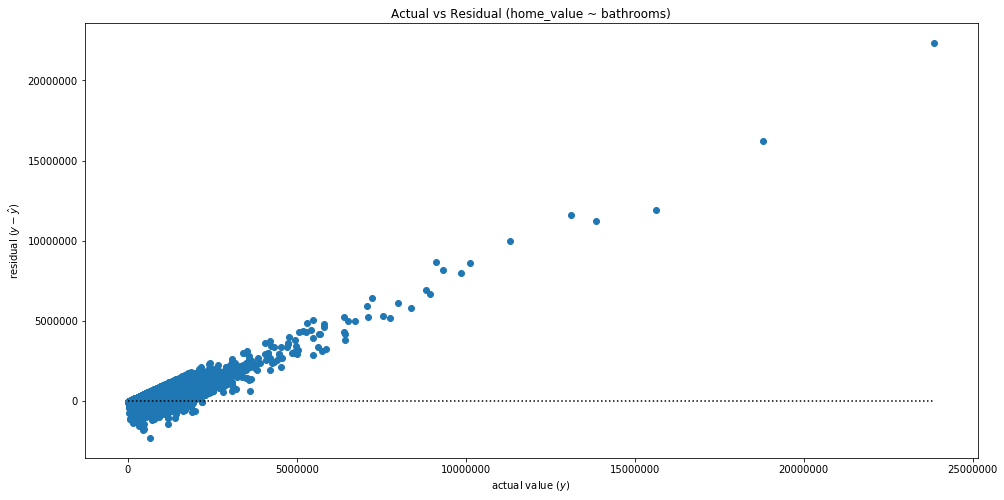

In [58]:
plt.figure(figsize=(16, 8))
ev.plot_residuals(predictions.actual_home_value, predictions["home_value ~ bathrooms"])
plt.ticklabel_format(axis="both", style="plain")
plt.show()

In [59]:
ev.regression_errors(predictions.actual_home_value, predictions["home_value ~ bathrooms"], predictions)

SSE    4513122674505799.000
ESS    1625739464482568.250
TSS    6138862138988367.000
MSE        376375838087.382
RMSE             613494.774
dtype: float64

In [60]:
ev.better_than_baseline(predictions.actual_home_value, predictions["home_value ~ bathrooms"], predictions.baseline_home_value, predictions)

Model performs better than baseline


In [61]:
predictions.apply(lambda c: math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual_home_value, c)))

actual_home_value                                      0.000
baseline_home_value                               731468.032
home_value ~ square_feet + bedrooms + bathrooms   567513.243
home_value ~ square_feet                          575620.094
home_value ~ bedrooms                             687498.490
home_value ~ bathrooms                            613494.774
dtype: float64

> home_value ~ square_feet + bedrooms + bathrooms is still the best model